<a href="https://colab.research.google.com/github/DiegoFleury/MI201-groupe-4/blob/main/notebooks/preProcessingAndEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing, Exploratory Data Analysis and (non-text) Feature Engineering
## MI201

##**Group 4** :
- Diego FLEURY CORRÊA DE MORAES
- Hazael SOLEDADE DE ARAUJO JUMONJI
- Lucas DE OLIVEIRA MARTIM

### Project 3 : **Sentiment Analysis Using LLMs**

###Introduction

This notebook is dedicated to handling the basic preprocessing and conducting Exploratory Data Analysis (EDA) for the project's associated dataset. The primary goal is to curate, investigate and visualize the data to uncover patterns, handle missing values, identify potential anomalies, and understand the relationships between features. By gaining insights from this analysis, we aim to prepare a solid foundation for the subsequent modeling stages of the project.

Feature engineering is also a concern of this notebook, albeit to a smaller degree, as the project focuses on BERT's embedding procedure (we will return to it on a separate, more detailed, notebook).

# Preprocessing


Let's first begin with importing the kaggle dataset:

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
path = kagglehub.dataset_download('abhi8923shriv/sentiment-analysis-dataset')

print('Data source import complete.')


Data source import complete.


Importing libraries (visualization, NLP, data handling, pipelining) :

In [2]:
# --------------- MAIN LIBRARIES ------------------

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from scipy.stats import chisquare
from sklearn.preprocessing import OneHotEncoder


# --------------- HELPING LIBRARIES ----------------
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

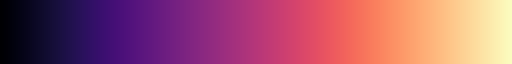

In [3]:
sns.set_theme(style="whitegrid", font_scale=1.2)
sns.color_palette("magma", as_cmap=True)

In [4]:
train_dataset = path+'/train.csv'
test_dataset = path+'/test.csv'

# Check if the path exists
print (os.path.exists(train_dataset))
print (os.path.exists(test_dataset))

True
True


In [5]:
# Load the CSV file into a DataFrame
train_df = pd.read_csv(train_dataset, encoding='ISO-8859-1')
test_df = pd.read_csv(test_dataset, encoding='ISO-8859-1')

Let's analyse a dataset sample:

In [6]:
train_df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


Taking from the original Kaggle competition data description (available [here](https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset/data)) :

"*There's a story behind every dataset and here's your opportunity to share yours.
training data was automatically created, as opposed to having humans manual annotate tweets. In our approach, we assume that any tweet with positive emoticons, like :), were positive, and tweets with negative emoticons, like :(, were negative.*"

We can notice that the data collection process was self supervised, and that the heuristic behind the label attribution was the emoticon present. This already biases our data, as it's more likely that certain groups (based on age, sex, country, etc) used these markers as a hole. A good starting point is, therefore, see the label/class balance.

... **but** first, let's look at the data.

In [7]:
print("Train DataFrame Info:")
train_df.info()
print("\n" + "-" * 50 + "\n")

print("Test DataFrame Info:")
test_df.info()

Train DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB

--------------------------------------------------

Test DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4815 entries, 0 to 4814
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------     

**A few key points**:

- It seems that the field `selected_text` isn't present in the text dataset, as so, it's probably best to discart it, as we will not be able to use it for estimating the models' generalization error.

- We have then 9 columns, 6 of which are categorical (`Dtype=object`) and 3 are numerical. One of them (`sentiment`) is the label, leaving us with 5 categorical features and 3 numerical ones.

- There seems to be very few missing values in the training dataset, but for some reason lots of them in the test data. This needs investigating.

## Non-Text preprocessing

###**Dropping columns**

The `textID` column is unlikely to yield any good results, due to it's strictly indexing purpose. Also, as aforementioned, the `selected_text` feature being not present in the test data is enough to drop it already.  

In [8]:
train_df = train_df.drop(columns=['textID', 'selected_text'])
test_df = test_df.drop(columns=['textID'])

**Handling nulls & imputation (label distribution)**

Let's analyse why does the test data has so many null values.

In [9]:
test_nulls = test_df[test_df.isnull()]
test_nulls

,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It seems that (as suspected) these are entire rows that are missing.

Null percentage: 26.6%


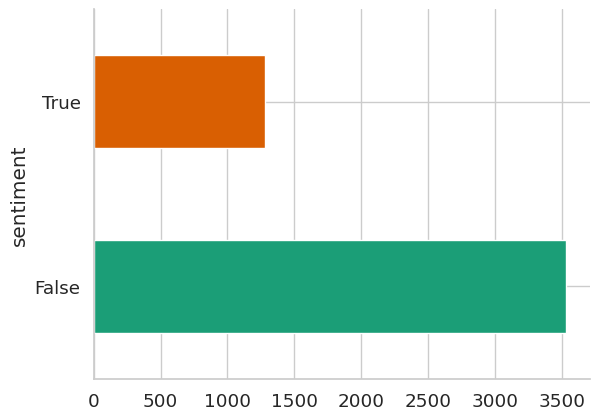

In [10]:
test_df.isnull().groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'));
plt.gca().spines[['top', 'right',]].set_visible(False);
print(f"Null percentage: {test_df.isnull().all(axis=1).sum() / test_df.shape[0] * 100:.1f}%")

In [11]:
test_df = test_df.dropna()

In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3534 entries, 0 to 3533
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   text              3534 non-null   object 
 1   sentiment         3534 non-null   object 
 2   Time of Tweet     3534 non-null   object 
 3   Age of User       3534 non-null   object 
 4   Country           3534 non-null   object 
 5   Population -2020  3534 non-null   float64
 6   Land Area (Km²)   3534 non-null   float64
 7   Density (P/Km²)   3534 non-null   float64
dtypes: float64(3), object(5)
memory usage: 248.5+ KB


Now let's see the training data.

In [13]:
train_df[train_df.isnull().any(axis=1)]


,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
314,NaN,neutral,night,31-45,Namibia,2540905,823000.0,3


From the data description, it seems that the self anotation procedure (with the subsequent emoji removal) resulted in this anomaly (the original text was probably a single emoji). It doesn't seem like keeping this would add any value to the training procedure, so lets remove it.

In [14]:
train_df = train_df.dropna()

###**Imputation**

Finally, in order to properly prepare for the future, we need to decide what to do in case of any missing data in the other columns.

- `text`: is assumed to hold the most predictive value, so any NaN value should be immediately discarded.
- `Time of Tweet`, `Age of User`, `Country`, `Population -2020`, `Land Area (Km²)`, `Density (P/Km²)` : Given that there doesn't seems to be any relevant missing data for these features, we can assume it will continue to be rare in the future and, therefore, just do a simple mode imputation for all of these values (taking care to not adjust the `Population -2020`, `Land Area (Km²)` and `Density (P/Km²)` columns conditioned on the `Country` column)

In [15]:
# Custom sklearn Transformer to drop rows/columns based on specific conditions
class CustomDropper(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Convert to DataFrame if it's not already one
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # Drop rows where all columns are null
        X = X.dropna(how='all')

        # Drop columns 'selected_text' e 'textID' se existirem, mas manter 'text'
        cols_to_drop = [col for col in ['selected_text', 'textID'] if col in X.columns]
        X = X.drop(columns=cols_to_drop, errors='ignore')

        return X

# Custom Transformer to handle missing values based on feature-specific logic
class CustomImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.global_mode = {}
        self.country_mode = {}

    def fit(self, X, y=None):
        # Global mode for 'Time of Tweet', 'Age of User', and 'Country'
        global_mode_columns = ['Time of Tweet', 'Age of User', 'Country']

        # Saves the mode directly (index 0) instead of the hole imputer
        self.global_mode = {col: X[col].mode()[0] for col in global_mode_columns if col in X.columns}

        # Mode conditioned on 'Country' for other columns
        conditional_columns = ['Population -2020', 'Land Area (Km²)', 'Density (P/Km²)']
        if 'Country' in X.columns:
            self.country_mode = {
                col: X.groupby('Country')[col].apply(lambda group: group.mode().iloc[0] if not group.mode().empty else None)
                for col in conditional_columns
                if col in X.columns
            }
        return self

    def transform(self, X):
        # Drop rows where 'text' is NaN
        if 'text' in X.columns:
            X = X.dropna(subset=['text'])

        # Impute global mode for 'Time of Tweet', 'Age of User', and 'Country'
        for col, mode_value in self.global_mode.items():
            if col in X.columns:
                X[col] = X[col].fillna(mode_value)

        # Impute conditional mode for 'Population -2020', 'Land Area (Km²)', and 'Density (P/Km²)'
        for col, mode_by_country in self.country_mode.items():
            if col in X.columns:
                X[col] = X[col].fillna(X['Country'].map(mode_by_country))

        return X

imputing_pipeline = Pipeline(steps=[
    ('custom_dropper', CustomDropper()),
    ('custom_imputer', CustomImputer())
])


### **Feature Encoding**

####**Categorical data preprocessing**

We have the following categorical (and also non-textual) data: `Time of Tweet`, `Age of User`, `Country`.

Looking on some tuple examples, we can see that it seems like the first 2 of these columns were actually once numerical values that were binned into (respectively) daytime period and age group / generation. This makes lots of sense, as the specifics of at what time and at what age we're exactly doesn't seem to be that useful in discerning the sentimental characteristics of a tweet (at least not without much more data about each individual).

In [16]:
train_df[['Time of Tweet', 'Age of User', 'Country']].head()

,Time of Tweet,Age of User,Country
0,morning,0-20,Afghanistan
1,noon,21-30,Albania
2,night,31-45,Algeria
3,morning,46-60,Andorra
4,noon,60-70,Angola


In [17]:
train_df['Time of Tweet'].unique(), train_df['Age of User'].unique(), train_df['Country'].unique()

(array(['morning', 'noon', 'night'], dtype=object),
 array(['0-20', '21-30', '31-45', '46-60', '60-70', '70-100'], dtype=object),
 array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
        'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
        'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
        'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
        'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
        'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', "Côte d'Ivoire",
        'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
        'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
        'Comoros', 'Congo (Congo-Brazzaville)', 'Costa Rica', 'Croatia',
        'Cuba', 'Cyprus', 'Czechia (Czech Republic)',
        'Democratic Republic of the Congo', 'Denmark', 'Djibouti',
        'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
        'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
   

In [18]:
def plot_categorical_distribution(data, column, palette="Set1"):
    """
    Generalized function to plot a categorical distribution with Seaborn.
    If the column has more than 10 unique categories, it will clip to the top 10 most frequent.

    Parameters:
    - data (DataFrame): The dataset containing the column to plot.
    - column (str): The column name to plot.
    - palette (str): Seaborn palette for coloring the bars.
    """

    # If the column has more than 10 unique categories, clip to the top 10 most frequent
    if data[column].nunique() > 10:
        top_values = data[column].value_counts().nlargest(10).index
        data = data[data[column].isin(top_values)]

    plt.figure(figsize=(6,4))
    sns.countplot(data=data, x=column, order=data[column].value_counts().index, palette=palette)
    plt.title(f'{column} Distribution', fontweight='bold')
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.xticks(rotation=90)
    plt.show()


<ipython-input-18-b4d73a52f345>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, order=data[column].value_counts().index, palette=palette)


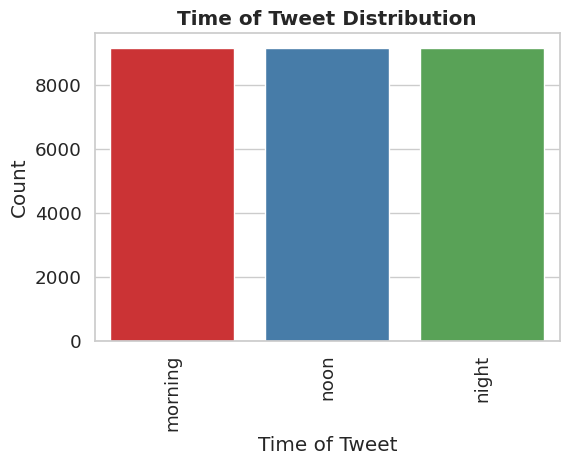

In [19]:
# Example for "Time of Tweet"
plot_categorical_distribution(
    data=train_df,
    column="Time of Tweet",
    palette="Set1"
);


<ipython-input-18-b4d73a52f345>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, order=data[column].value_counts().index, palette=palette)


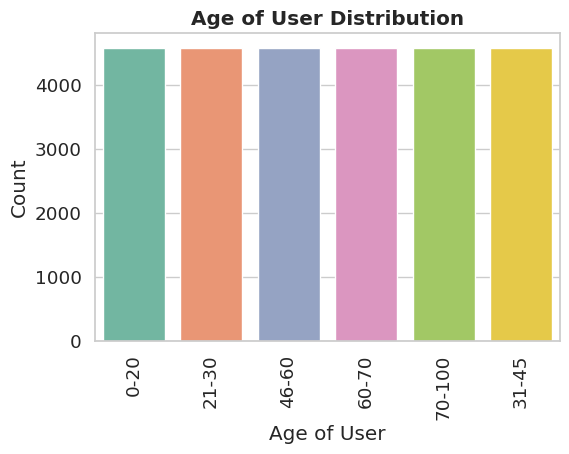

In [20]:
# Example for "Age of User"
plot_categorical_distribution(
    data=train_df,
    column="Age of User",
    palette="Set2"
)

<ipython-input-18-b4d73a52f345>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, order=data[column].value_counts().index, palette=palette)


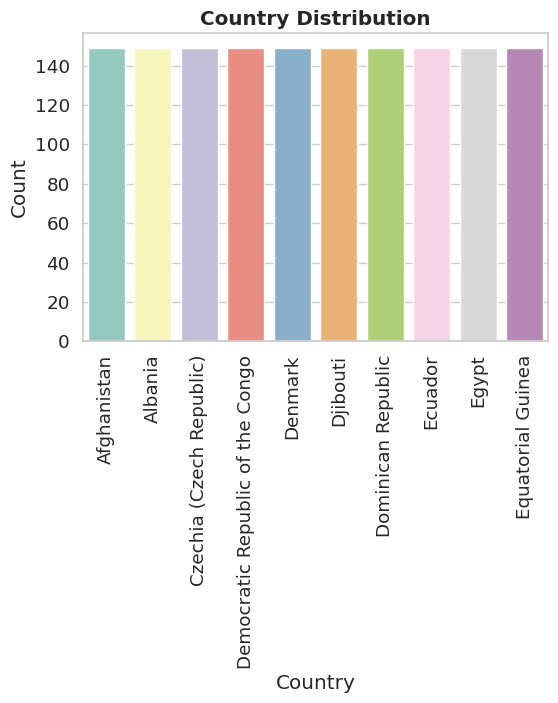

In [21]:
# Example for "Country" (only top 10 countries)
plot_categorical_distribution(
    data=train_df,
    column="Country",
    palette="Set3"
)

It seems that all data looks pretty (abnormally) balanced. Let's check concretely if this is true by performing a homogeneity test.

In [22]:
def perform_homogeneity_test(data, column):
    """
    Performs a Chi-Square Goodness of Fit Test to check if the data is abnormally balanced.

    Parameters:
    - data (DataFrame): The dataset containing the column to test.
    - column (str): The categorical column name to test.

    Returns:
    - p-value (float): The p-value from the Chi-Square test.
    - Result (str): Interpretation of the p-value.
    """
    # Calculate observed frequencies
    observed_frequencies = data[column].value_counts()

    # Calculate expected frequencies (assuming a uniform distribution)
    n_categories = observed_frequencies.size
    total_count = observed_frequencies.sum()
    expected_frequencies = [total_count / n_categories] * n_categories

    # Perform Chi-Square Goodness of Fit Test
    chi2_stat, p_value = chisquare(f_obs=observed_frequencies, f_exp=expected_frequencies)

    # Interpretation of the result
    if p_value < 0.05:
        result = "The distribution is NOT homogeneous (imbalanced)."
    else:
        result = "The distribution is homogeneous (balanced)."

    print(f" ----------- Homogeneity results for column {column} ---------- ")
    print(f"Chi-Square Statistic: {chi2_stat:.2f}")
    print(f"P-value: {p_value:.4f}")
    print(f"Result: {result}")
    print(" -------------------------------------- ",'\n')


In [23]:
perform_homogeneity_test(train_df, "Time of Tweet")
perform_homogeneity_test(train_df, "Age of User")
perform_homogeneity_test(train_df, "Country")


 ----------- Homogeneity results for column Time of Tweet ---------- 
Chi-Square Statistic: 0.00
P-value: 0.9999
Result: The distribution is homogeneous (balanced).
 --------------------------------------  

 ----------- Homogeneity results for column Age of User ---------- 
Chi-Square Statistic: 0.00
P-value: 1.0000
Result: The distribution is homogeneous (balanced).
 --------------------------------------  

 ----------- Homogeneity results for column Country ---------- 
Chi-Square Statistic: 147.13
P-value: 0.9949
Result: The distribution is homogeneous (balanced).
 --------------------------------------  



In [24]:
train_df["Country"].value_counts().unique()

array([149, 148, 147, 127])

It seems that the dataset was, therefore, artificially curated to have the most balance possible amongst the categorical variables.

For the first 2 variables, as they are ordinal, we have a natural procedure for transforming them in terms of useful numerical features (as most models accept only these types of representations).

For the `Country` column, it is worth noting that it naturally lends itself to an alternative representation: continents. While reducing the data to features like population and population density might seem straightforward, it risks losing the cultural and regional nuances associated with each country. On the other hand, performing a one-hot encoding for every individual country would result in an overly complex and high-dimensional feature space. To achieve a balance, we opted to group countries by their respective continents, offering a more manageable yet meaningful representation.

This may seem crude, but we need to remember that, either by translation or by design (selection) all of the texts in the tweets are already in english, therefore, althought balanced, the dataset is already heavily culturally biased. The text processing parts of the pipeline (not present in this notebook) already makes use of this property.

In [25]:
# Let's take a few non-english speaking countries
countries = ["China", "Somalia", "Colombia"]

print("Examples of texts in English by Country:")
for country in countries:
    print(f"\nCountry: {country}")
    texts = train_df[train_df["Country"] == country]["text"].head(3)
    for i, text in enumerate(texts, start=1):
        print(f"{i}. {text}")


Examples of texts in English by Country:

Country: China
1. Born and raised in NYC and living in Texas for the past 10 years!  I still miss NY
2. Screw the reviews, I thought Wolverine was awesome. But not enough Dominic Monaghan for my liking.
3. I`m so hunrgy right now and these heels kill me I can hardly walk in them

Country: Somalia
1. My back hurts...really bad
2.  ohoh i missed all ur tweets  im gonna have to stay awake all night to see the announcement now, **** time difference
3. Having dinner with my grandma since I couldn`t be with my mum.

Country: Colombia
1. just in case you wonder, we are really busy today and this coming with with adding tons of new blogs and updates stay tuned
2. If you followed us recently, PLEASE dont be offended that we haven`t followed back. We hit our limit.   Hopefully we will be free soon.
3. both electronic keys stopped working. there is no keyhole! cant get in my car. so much for technology


In [26]:
# Ordinal categorical varibles first

# Age
class AgeRangeToMedianTransformer(BaseEstimator, TransformerMixin):
    """
    Transformer to convert age ranges (e.g., '0-20', '21-30') into their median values.
    """
    def fit(self, X, y=None):
        return self  # No fitting is needed for this transformer

    def transform(self, X):
        return X.apply(self._convert_age_range_to_median).values.reshape(-1, 1)

    @staticmethod
    def _convert_age_range_to_median(age_range):
        try:
            lower, upper = map(int, age_range.split('-'))
            return (lower + upper) / 2
        except ValueError:
            raise ValueError(f"Invalid age range format: {age_range}")


# Time of Tweet
class TimeOfDayToNumericTransformer(BaseEstimator, TransformerMixin):
    """
    Transformer to convert time of day (e.g., 'morning', 'noon', 'night') into numerical values.
    """
    def __init__(self, mapping=None):
        # Default mapping: 'morning' -> 0, 'noon' -> 1, 'night' -> 2
        self.mapping = mapping or {'morning': 0, 'noon': 1, 'night': 2}

    def fit(self, X, y=None):
        return self  # No fitting is needed for this transformer

    def transform(self, X):
        return X.apply(self._convert_time_of_day_to_numeric).values.reshape(-1, 1)

    def _convert_time_of_day_to_numeric(self, time_of_day):
        if time_of_day not in self.mapping:
            raise ValueError(f"Invalid time of day: {time_of_day}")
        return self.mapping[time_of_day]



In [27]:
train_df.Country.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', "Côte d'Ivoire",
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Congo-Brazzaville)', 'Costa Rica', 'Croatia',
       'Cuba', 'Cyprus', 'Czechia (Czech Republic)',
       'Democratic Republic of the Congo', 'Denmark', 'Djibouti',
       'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini (fmr. "Swaziland")', 'Ethiopia', 'Fiji', 'Finland',
       'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana',
       'Gr

In [28]:
# The reverse dict is easier to handle
continent_to_countries = {
    "Africa": [
        'Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi',
        'Cabo Verde', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros',
        'Congo (Congo-Brazzaville)', "Côte d'Ivoire", 'Democratic Republic of the Congo', 'Djibouti',
        'Egypt', 'Equatorial Guinea', 'Eritrea', 'Eswatini (fmr. "Swaziland")',
        'Ethiopia', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau',
         'Kenya', 'Lesotho', 'Liberia', 'Libya', 'Madagascar',
        'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Morocco', 'Mozambique',
        'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'Sao Tome and Principe',
        'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa',
        'South Sudan', 'Sudan', 'Tanzania', 'Togo', 'Tunisia', 'Uganda',
        'Zambia', 'Zimbabwe'
    ],
    "Asia": [
        'Afghanistan', 'Armenia', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Bhutan',
        'Brunei', 'Cambodia', 'China', 'Cyprus', 'Georgia', 'India', 'Indonesia',
        'Iran', 'Iraq', 'Israel', 'Japan', 'Jordan', 'Kazakhstan', 'Kuwait',
        'Kyrgyzstan', 'Laos', 'Lebanon', 'Malaysia', 'Maldives', 'Mongolia',
        'Myanmar (formerly Burma)', 'Nepal', 'North Korea', 'Oman', 'Pakistan',
        'Palestine State', 'Philippines', 'Qatar', 'Saudi Arabia', 'Singapore',
        'South Korea', 'Sri Lanka', 'Syria', 'Tajikistan', 'Thailand', 'Timor-Leste',
        'Turkey', 'Turkmenistan', 'United Arab Emirates', 'Uzbekistan', 'Vietnam',
        'Yemen'
    ],
    "Europe": [
        'Albania', 'Andorra', 'Austria', 'Belarus', 'Belgium', 'Bosnia and Herzegovina',
        'Bulgaria', 'Croatia', 'Czechia (Czech Republic)', 'Denmark', 'Estonia', 'Finland',
        'France', 'Germany', 'Greece', 'Holy See', 'Hungary', 'Iceland', 'Ireland', 'Italy',
        'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Moldova',
        'Monaco', 'Montenegro', 'Netherlands', 'North Macedonia', 'Norway', 'Poland',
        'Portugal', 'Romania', 'Russia', 'San Marino', 'Serbia', 'Slovakia',
        'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Ukraine', 'United Kingdom'
    ],
    "North America": [
        'Antigua and Barbuda', 'Bahamas', 'Barbados', 'Belize', 'Canada', 'Costa Rica',
        'Cuba', 'Dominica', 'Dominican Republic', 'El Salvador', 'Grenada',
        'Guatemala', 'Haiti', 'Honduras', 'Jamaica', 'Mexico', 'Nicaragua',
        'Panama', 'Saint Kitts and Nevis', 'Saint Lucia',
        'Saint Vincent and the Grenadines', 'Trinidad and Tobago',
        'United States of America'
    ],
    "South America": [
        'Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Guyana',
        'Paraguay', 'Peru', 'Suriname', 'Uruguay', 'Venezuela'
    ],
    "Oceania": [
        'Australia', 'Fiji', 'Kiribati', 'Marshall Islands', 'Micronesia', 'Nauru',
        'New Zealand', 'Palau', 'Papua New Guinea', 'Samoa', 'Solomon Islands',
        'Tonga', 'Tuvalu', 'Vanuatu'
    ]
}

# Inverting the dictionary
country_to_continent = {
    country: continent
    for continent, countries in continent_to_countries.items()
    for country in countries
}

# Unique countries in train_df
unique_countries_in_df = set(train_df['Country'].unique())

# Countries in the `country_to_continent` dictionary
countries_in_dict = set(country_to_continent.keys())

# Check if every country in train_df is in the dictionary
missing_in_dict = unique_countries_in_df - countries_in_dict
if missing_in_dict:
    print(f"Countries in train_df but missing in dictionary: {missing_in_dict}")
else:
    print("All countries in train_df are present in the dictionary.")

# Check if every country in the dictionary is in train_df
missing_in_df = countries_in_dict - unique_countries_in_df
if missing_in_df:
    print(f"Countries in dictionary but missing in train_df: {missing_in_df}")
else:
    print("All countries in the dictionary are present in train_df.")

All countries in train_df are present in the dictionary.
All countries in the dictionary are present in train_df.


In [29]:
# Mapping all countries to their respective continents, followed by a one hot encoding
class ContinentOneHotTransformer(BaseEstimator, TransformerMixin):
    """
    Transformer to map a country to its continent and apply One-Hot Encoding.
    """
    def __init__(self, country_to_continent):
        """
        Parameters:
        - country_to_continent (dict): A dictionary mapping countries to continents.
        """
        self.country_to_continent = country_to_continent
        self.encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    def fit(self, X, y=None):
        """
        Store the unique continents for encoding.
        X is expected to be a pandas Series of country names.
        """
        # Map countries to continents
        continents = X.map(self.country_to_continent).dropna()
        # Fit the OneHotEncoder on the mapped continents
        self.encoder.fit(continents.values.reshape(-1, 1))
        return self

    def transform(self, X):
        """
        Transform countries into continents and apply One-Hot Encoding.
        """
        # Map countries to continents
        continents = X.map(self.country_to_continent)
        # Apply OneHotEncoder to the mapped continents
        return self.encoder.transform(continents.values.reshape(-1, 1))


####**Numerical data preprocessing**

Now let's look at the final columns for patterns.

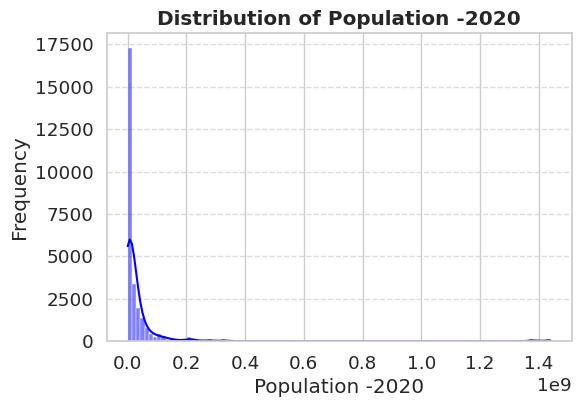

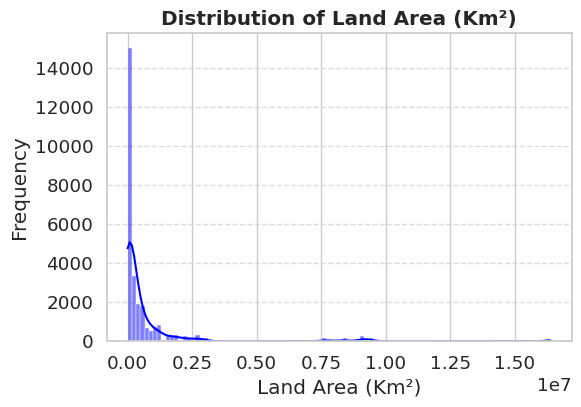

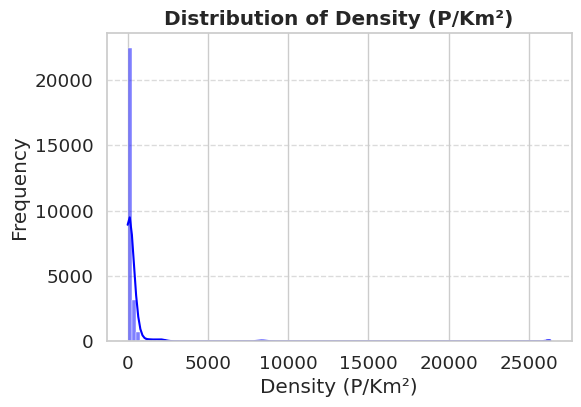

In [30]:
# Histograms for each numerical feature
num_features = ['Population -2020', 'Land Area (Km²)', 'Density (P/Km²)']

for feature in num_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(train_df[feature], kde=True, bins=100, color='blue')
    plt.title(f'Distribution of {feature}', fontweight='bold')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

It seems that the distributions of the country statistics are hard to decode, as they're clustered way too much around the lower values. It's hardly discernible from the naked eye, so let's apply a log transform to better visualize the patterns.

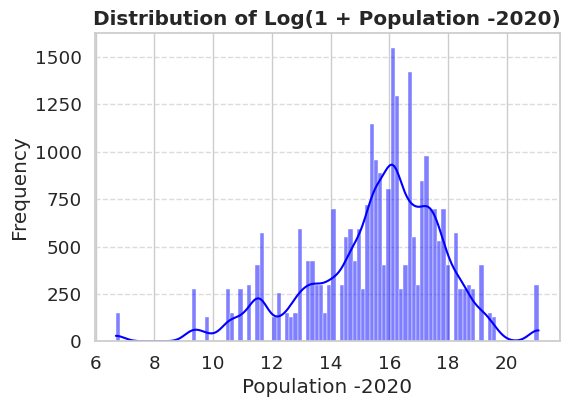

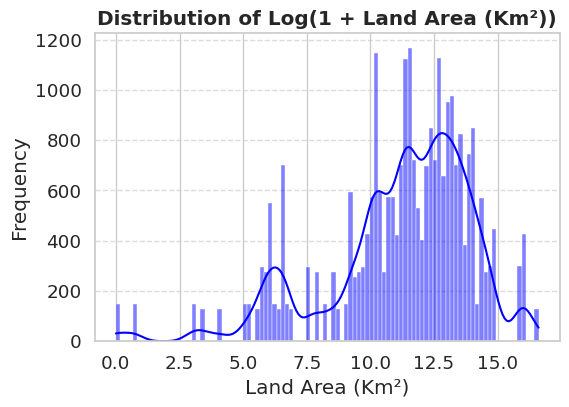

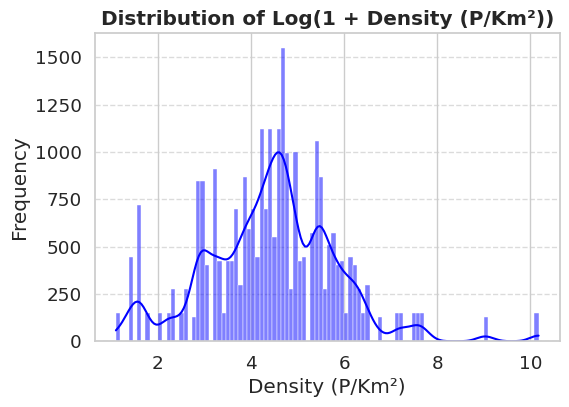

In [31]:
# Histograms for each numerical feature
num_features = ['Population -2020', 'Land Area (Km²)', 'Density (P/Km²)']

log_num_features = []
for feature in num_features:
    plt.figure(figsize=(6, 4))
    log_num_features.append(f'log1p_{feature}')
    sns.histplot(train_df[feature].apply(lambda x: np.log1p(x)), kde=True, bins=100, color='blue')
    plt.title(f'Distribution of Log(1 + {feature})', fontweight='bold')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Much better ! It seems that the logarithm of both the population and land area are bimodal, with the log density being interestingly not. Nevertheless, let's take a look at the pairwise relationships before jumping into conclusions.  

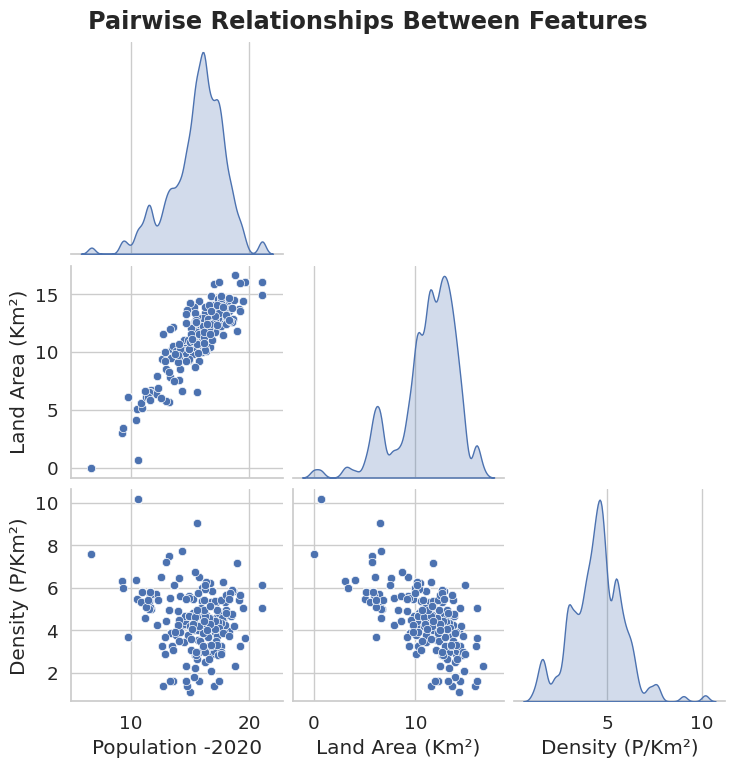

In [32]:
# Pairwise relationships (correlation plots)
sns.pairplot(train_df[num_features].apply(lambda x: np.log1p(x)), diag_kind='kde', corner=True)
plt.suptitle('Pairwise Relationships Between Features', y=1.02, fontweight='bold')
plt.show()

The somewhat positive linear trend between the logarithm of the population and of the land area (and the negative between the logarithm of land area with density) make intuitive sense: it's more likely that bigger countries have larger populations and it's also more likely that denser populations happen in smaller countries.

The most interesting part comes from the other plot : knowing a country's density isn't that informative with respect to it's population.

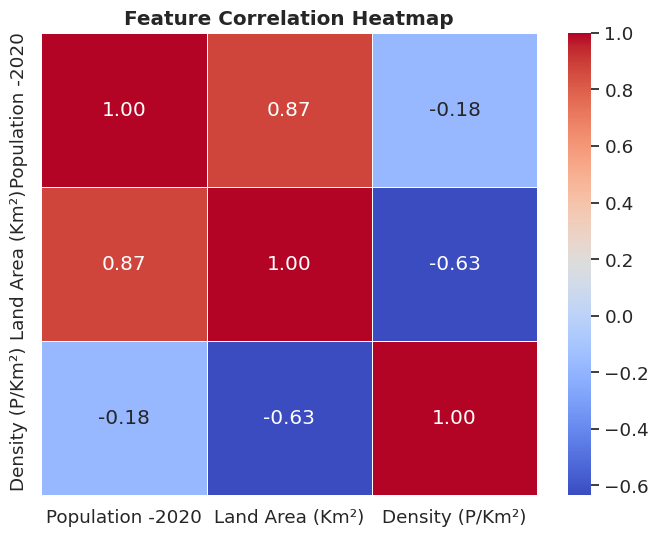

In [33]:
# Heatmap for correlations
plt.figure(figsize=(8, 6))
correlation_matrix = train_df[num_features].apply(lambda x: np.log1p(x)).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Heatmap', fontweight='bold')
plt.show()

This logarithmic transformation seem to be useful for a representation of the data, and clearer patterns can be seem in 2 out of the 3 plots, so we might as well add it. The model will likely perform better int the transformed space as the relationships are easier to see. This information, in conjunction with the continental encoding, will likely enable the model to locate a person's country. This, alongside the actual numerical values (that can be useful), will likely serve to the model as a proxy for culture, witch is expected to be useful in the presence of new text.   

So let's add the transformer!

In [34]:

class LogTransformer(TransformerMixin, BaseEstimator):
    """
    A custom transformer that applies a log1p transformation to a single feature.
    """

    def __init__(self):
        pass  # No parameters needed

    def fit(self, X, y=None):
        return self  # No fitting needed

    def transform(self, X):
        """
        Applies log1p transformation to a single feature (Series).

        Args:
            X (pd.Series or np.ndarray): Input feature column.

        Returns:
            np.ndarray: Transformed feature column in a 2D format.
        """
        if not isinstance(X, (pd.Series, np.ndarray)):
            raise ValueError("LogTransformer expects a pandas Series or NumPy array as input.")

        return np.log1p(X).values.reshape(-1, 1)

Let's look for correlations with the label, perhaps there are some useful

### **Final pre-processing pipeline**

In [35]:
column_preprocessor = ColumnTransformer(
    transformers=[
        ('age_range_2_median', AgeRangeToMedianTransformer(), 'Age of User'),
        ('time_range_2_numeric', TimeOfDayToNumericTransformer(), 'Time of Tweet'),
        ('country_2_continent_one_hot', ContinentOneHotTransformer(country_to_continent=country_to_continent), 'Country'),
        ('population',LogTransformer() , 'Population -2020'),
        ('land_area', LogTransformer(), 'Land Area (Km²)'),
        ('density', LogTransformer(), 'Density (P/Km²)')
    ],
    remainder='passthrough'
)

In [36]:
pre_processing_pipeline = Pipeline(steps=[
    ('column_preprocessor', column_preprocessor)
])

In [37]:
pre_processed_train_df = pd.DataFrame(pre_processing_pipeline.fit_transform(train_df), columns = ["Age_median", "Time_of_Tweet_numeric", "Africa", "Asia","Europe","North America", "South America", "Oceania", "Log Population", "Log Land Area", "Log Density", "Text", "Sentiment"])

In [38]:
pre_processed_train_df.head()

,Age_median,Time_of_Tweet_numeric,Africa,Asia,Europe,North America,South America,Oceania,Log Population,Log Land Area,Log Density,Text,Sentiment
0,10.0,0,0.0,1.0,0.0,0.0,0.0,0.0,17.477233,13.38912,4.110874,"I`d have responded, if I were going",neutral
1,25.5,1,0.0,0.0,1.0,0.0,0.0,0.0,14.872536,10.218335,4.663439,Sooo SAD I will miss you here in San Diego!!!,negative
2,38.0,2,1.0,0.0,0.0,0.0,0.0,0.0,17.596309,14.683342,2.944439,my boss is bullying me...,negative
3,53.0,0,0.0,0.0,1.0,0.0,0.0,0.0,11.255009,6.154858,5.105945,what interview! leave me alone,negative
4,65.0,1,1.0,0.0,0.0,0.0,0.0,0.0,17.307958,14.036011,3.295837,"Sons of ****, why couldn`t they put them on t...",negative


In [39]:
pre_processing_pipeline.named_steps['column_preprocessor']

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


ColumnTransformer(remainder='passthrough',
                  transformers=[('age_range_2_median',
                                 AgeRangeToMedianTransformer(), 'Age of User'),
                                ('time_range_2_numeric',
                                 TimeOfDayToNumericTransformer(mapping={'morning': 0,
                                                                        'night': 2,
                                                                        'noon': 1}),
                                 'Time of Tweet'),
                                ('country_2_continent_one_hot',
                                 ContinentOneHotTransformer(country_to_continent={'Afghanistan': 'Asia',
                                                                                  'Albania': 'Europe...
                                                                                  'Bosnia and Herzegovina': 'Europe',
                                                                                  'Botswana': 'Africa',
                                                                                  'Brazil': 'South '
                                                                                            'America',
                                                                                  'Brunei': 'Asia',
                                                                                  'Bulgaria': 'Europe',
                                                                                  'Burkina Faso': 'Africa',
                                                                                  'Burundi': 'Africa',
                                                                                  'Cabo Verde': 'Africa',
                                                                                  'Cambodia': 'Asia', ...}),
                                 'Country'),
                                ('population', LogTransformer(),
                                 'Population -2020'),
                                ('land_area', LogTransformer(),
                                 'Land Area (Km²)'),
                                ('density', LogTransformer(),
                                 'Density (P/Km²)')])

# Feature Engineering

Look at the following distributions:

- Age
- Time of tweet
- Population, Land Area, Population Density

In [40]:
def plot_pairwise_relationships(df, features, title="Pairwise Relationships"):
    """
    Generates a Seaborn pairplot using the specified features and label column.]
    It already assumes it's for the sentiment analysis task.

    Args:
        df (pd.DataFrame): The dataset containing the features and labels.
        features (list): List of numerical feature names to be included in the plot.
        title (str, optional): The title of the plot. Defaults to "Pairwise Relationships".

    Returns:
        None
    """

    # Define a color palette based on labels
    custom_palette = {
      'neutral': 'green',
      'negative': 'red',
      'positive': 'blue'
    }

    # Generate the pairplot
    sns.pairplot(
        df[features + ["sentiment"]],
        hue="sentiment",
        diag_kind="kde",
        palette=custom_palette,
        corner=True
    )

    # Adjust the title
    plt.suptitle(title, y=1.02, fontweight="bold")
    plt.show()


In [41]:
full_preprocessing_df_concat = pd.concat([pre_processed_train_df , train_df[["sentiment"]]], axis=1)

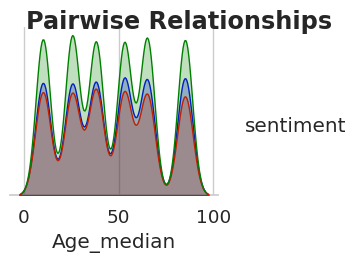

In [42]:
plot_pairwise_relationships(full_preprocessing_df_concat, ["Age_median"])

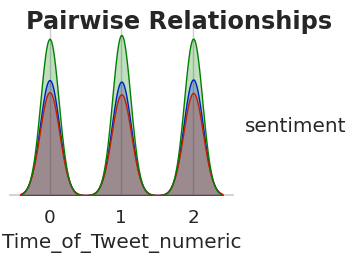

In [43]:
plot_pairwise_relationships(full_preprocessing_df_concat, ["Time_of_Tweet_numeric"])

Look for correlations between data and with the label.

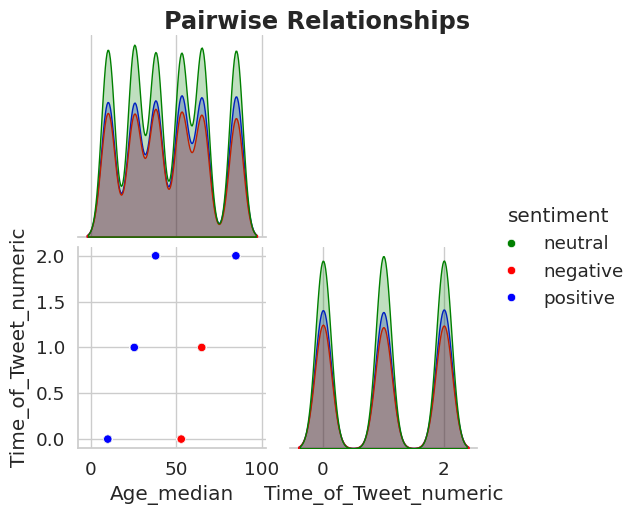

In [44]:
plot_pairwise_relationships(full_preprocessing_df_concat, ["Age_median", "Time_of_Tweet_numeric"])

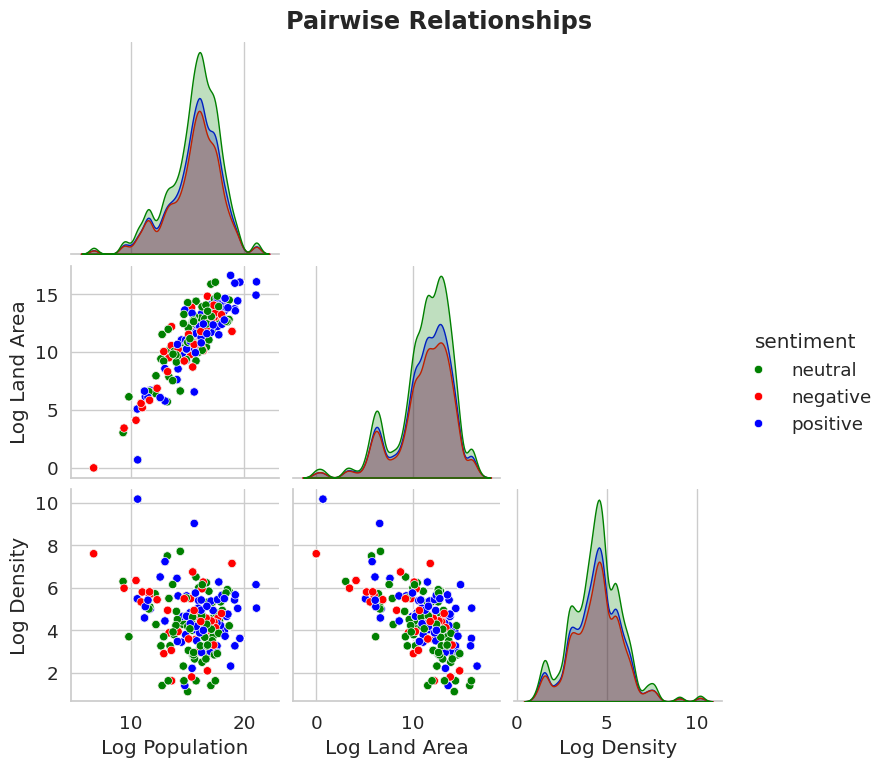

In [45]:
plot_pairwise_relationships(full_preprocessing_df_concat, ["Log Population", "Log Land Area", "Log Density"])

There doesn't seem to be any obvious pattern that can be useful in these features, therefore, we'll leave them as they're.

# Final pipeline


In the end, we have the following (non-text) preprocessor

In [46]:
full_pipeline = Pipeline([
    ('imputing and dropping', imputing_pipeline),
    ('pre-processing', pre_processing_pipeline)
])

pre_processed_train_df = pd.DataFrame(full_pipeline.fit_transform(train_df), columns =["Age_median", "Time_of_Tweet_numeric", "Africa", "Asia","Europe","North America", "South America", "Oceania", "Log Population", "Log Land Area", "Log Density", "Text", "Sentiment"] )
pre_processed_test_df = pd.DataFrame(full_pipeline.transform(test_df), columns = ["Age_median", "Time_of_Tweet_numeric", "Africa", "Asia","Europe","North America", "South America", "Oceania", "Log Population", "Log Land Area", "Log Density", "Text", "Sentiment"])

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [47]:
pre_processed_train_df

,Age_median,Time_of_Tweet_numeric,Africa,Asia,Europe,North America,South America,Oceania,Log Population,Log Land Area,Log Density,Text,Sentiment
0,10.0,0,0.0,1.0,0.0,0.0,0.0,0.0,17.477233,13.38912,4.110874,"I`d have responded, if I were going",neutral
1,25.5,1,0.0,0.0,1.0,0.0,0.0,0.0,14.872536,10.218335,4.663439,Sooo SAD I will miss you here in San Diego!!!,negative
2,38.0,2,1.0,0.0,0.0,0.0,0.0,0.0,17.596309,14.683342,2.944439,my boss is bullying me...,negative
3,53.0,0,0.0,0.0,1.0,0.0,0.0,0.0,11.255009,6.154858,5.105945,what interview! leave me alone,negative
4,65.0,1,1.0,0.0,0.0,0.0,0.0,0.0,17.307958,14.036011,3.295837,"Sons of ****, why couldn`t they put them on t...",negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27475,38.0,2,1.0,0.0,0.0,0.0,0.0,0.0,17.251848,12.335086,4.927254,wish we could come see u on Denver husband l...,negative
27476,53.0,0,0.0,0.0,1.0,0.0,0.0,0.0,16.159531,11.7668,4.406719,I`ve wondered about rake to. The client has ...,negative
27477,65.0,1,0.0,0.0,0.0,1.0,0.0,0.0,11.630922,5.831882,5.805135,Yay good for both of you. Enjoy the break - y...,positive
27478,85.0,2,0.0,0.0,0.0,1.0,0.0,0.0,16.701181,11.582088,5.123964,But it was worth it ****.,positive


In [48]:
pre_processed_test_df

,Age_median,Time_of_Tweet_numeric,Africa,Asia,Europe,North America,South America,Oceania,Log Population,Log Land Area,Log Density,Text,Sentiment
0,10.0,0,0.0,1.0,0.0,0.0,0.0,0.0,17.477233,13.38912,4.110874,Last session of the day http://twitpic.com/67ezh,neutral
1,25.5,1,0.0,0.0,1.0,0.0,0.0,0.0,14.872536,10.218335,4.663439,Shanghai is also really exciting (precisely -...,positive
2,38.0,2,1.0,0.0,0.0,0.0,0.0,0.0,17.596309,14.683342,2.944439,"Recession hit Veronique Branquinho, she has to...",negative
3,53.0,0,0.0,0.0,1.0,0.0,0.0,0.0,11.255009,6.154858,5.105945,happy bday!,positive
4,65.0,1,1.0,0.0,0.0,0.0,0.0,0.0,17.307958,14.036011,3.295837,http://twitpic.com/4w75p - I like it!!,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3529,25.5,1,0.0,0.0,0.0,1.0,0.0,0.0,15.706294,11.698085,4.025352,"its at 3 am, im very tired but i can`t sleep ...",negative
3530,38.0,2,1.0,0.0,0.0,0.0,0.0,0.0,17.002138,14.051926,2.995732,All alone in this old house again. Thanks for...,positive
3531,53.0,0,1.0,0.0,0.0,0.0,0.0,0.0,19.144064,13.722047,5.42495,I know what you mean. My little dog is sinkin...,negative
3532,65.0,1,0.0,1.0,0.0,0.0,0.0,0.0,17.065064,11.698666,5.370638,_sutra what is your next youtube video gonna b...,positive


It seems safe now to save it to a file, for further processing in the next steps of the process.

In [50]:
pre_processed_train_df.to_csv("processed_train.csv", index=False)
pre_processed_test_df.to_csv("processed_test.csv", index=False)
